In [4]:
import numpy as np
import os
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import metrics
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.applications import mobilenet_v2
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D, Dropout, Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer

from keras_visualizer import visualizer 


In [8]:
df_image_MoA = pd.read_csv('df_image_MoA.csv')

## Set up data input

### Prepare images by converting PNGs to arrays

In [127]:
def prepare_image(img_path):
    """ Takes in an image number, loads the png, and converts to array"""
    try:        
        img = image.load_img('raw_images/'+str(img_path)+'.png', target_size=(224, 224))
    except: 
        print(img_path)
    else:
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = mobilenet_v2.preprocess_input(x)
        return x

In [18]:
# Get list of images
image_list = list(df_image_MoA.Image)

# Loop through images and collect propessed arrays into list
array_list = []
for image_ in image_list:
    array_list.append(prepare_image(image_))
    


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
11435497
26000
11435498


In [19]:
image_array = np.vstack(array_list[0:25998])

In [132]:
np.save('image_array', image_array, allow_pickle = True)

In [9]:
image_array = np.load('image_array.npy')

### Define the y-target (mechanism of action) of interest and create train-val-test splits

Methods used for test-train split
1. sklearn train-test split, Keras validation split
    - Keras only takes the last part of data, does not shuffle
2. sklearn train-test split, sklearrn train-validation split
    - Uneven number of target and non-target class
3. Stratify the train-test split and train-validation split
    - Equal number of target and non-target class 

Methods used for category encodin
1. One-hot encoding using np_utils.to_categorical
    - Creates an (x,2) array 
    - Resulted in having an equal number of true positives and true negatives in the validation data. 
    - True positives + false positives = total data set
2. 

In [10]:
def get_MoA(MoA):
    """Returns train-test split stratified on target class(MoA)"""    
    df_image_MoA['Category'] = np.where(df_image_MoA['Compound MoA'] == MoA, 1, 0)
    
    # Assign X and y 
    X_ = image_array
    y_ = df_image_MoA['Category'][0:25998]

    # Train-test split
    X_train_, X_test, y_train_, y_test = (train_test_split(X_, y_, 
                                                     test_size = .2, random_state = 22, stratify = y_))
    y_test = y_test.astype('float32')
    
    X_train, X_valid, y_train, y_valid = (train_test_split(X_train_, y_train_, 
                                                     test_size = .25, random_state = 22, stratify = y_train_))
    
    y_train = y_train.astype('float32')
    y_valid = y_valid.astype('float32')
    return X_train, y_train, X_test, y_test, X_valid, y_valid

In [11]:
X_train, y_train_cat, X_test, y_test_cat, X_valid, y_valid_cat = get_MoA('GPCR agonist')

Check the shape of each split

In [12]:
# Need to convert y labels from series to numpy arrays
y_test_array = y_test_cat.to_numpy()
y_train_array = y_train_cat.to_numpy()
y_valid_array = y_valid_cat.to_numpy()

## Test different hyperparameters on a CNN

### First set of experiments
#### CNN models from scratch
1. NN_scratch - initial attempt
    - Did not do better than chance
2. NN_scratch1 - add convolution layer
    - Did not do better than chance
3. NN_scratch2 - add dense layer 
    - Did not do better than chance
4. NN_scratch3 - change activation functions from ReLU to LeakyReLU
    - This helped very slightly
5. NN_scratch4 - add in class weights to address class imbalances
    - This seems to be key to allow some learning from the CNN

#### CNN models with transfer learning
NN_trans - mobilenet2 pre-trained model
    - No better than chance
NN_trans - resnet50 pre-trained model
    - No better than chance
    
### Second set of experiments

#### CNN models from scratch
Repeat NN_scratch, NN_scratch1, NN_scratch2, and NN_scratch3 with class imbalances

1. NN_scratch 
    - Best epoch: 2, AUC_PR = 0.739
2. NN_scratch1 - add convolution layer
    - Just horrible, never found true positives
3. NN_scratch2 - add dense layer
    - Best epoch: 0.0703 
4. NN_scratch3 - change activation function from ReLU to LeakyReLU
    - 



In [124]:
tensorboard = TensorBoard(log_dir = 'logs/NN_scratch')

In [19]:
metrics_ = [metrics.AUC(curve='ROC'), metrics.AUC(curve = 'PR'), metrics.Recall(), metrics.Precision(), metrics.PrecisionAtRecall(0.5), metrics.TruePositives(), metrics.TrueNegatives(), metrics.FalseNegatives(), metrics.FalsePositives()]
class_weights = {0:1, 1:15}

In [90]:
class_weights = {0:1, 1:15}
NN_scratch = Sequential(
                        [InputLayer(input_shape=X_train.shape[1:]),
                         Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Flatten(),
                         Dense(32, activation='relu'),
                         Dropout(0.20),
                         Dense(1, activation='sigmoid')]
                       )

NN_scratch.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics = metrics_,
)


In [126]:
NN_scratch.fit(X_train, y_train_array, epochs=10, verbose=1, batch_size = 100, class_weight = class_weights, validation_data = (X_valid, y_valid_array), callbacks=[tensorboard])

Epoch 1/10
156/156 [==============================] - 483s 3s/step - loss: 0.2718 - auc_2: 0.9852 - auc_3: 0.9119 - recall_1: 0.9249 - precision_1: 0.4359 - precision_at_recall_1: 0.9984 - true_positives_1: 911.0000 - true_negatives_1: 13434.0000 - false_negatives_1: 74.0000 - false_positives_1: 1179.0000 - val_loss: 0.6571 - val_auc_2: 0.5133 - val_auc_3: 0.0656 - val_recall_1: 0.2287 - val_precision_1: 0.0673 - val_precision_at_recall_1: 0.0666 - val_true_positives_1: 75.0000 - val_true_negatives_1: 3832.0000 - val_false_negatives_1: 253.0000 - val_false_positives_1: 1040.0000
Epoch 2/10
156/156 [==============================] - 500s 3s/step - loss: 0.2660 - auc_2: 0.9857 - auc_3: 0.9136 - recall_1: 0.9431 - precision_1: 0.3968 - precision_at_recall_1: 1.0000 - true_positives_1: 929.0000 - true_negatives_1: 13201.0000 - false_negatives_1: 56.0000 - false_positives_1: 1412.0000 - val_loss: 0.5644 - val_auc_2: 0.5141 - val_auc_3: 0.0680 - val_recall_1: 0.2165 - val_precision_1: 0.0785

In [127]:
results = NN_scratch.evaluate(X_test, y_test)
print(results)

163/163 [==============================] - 37s 195ms/step - loss: 0.7319 - auc_2: 0.5124 - auc_3: 0.0657 - recall_1: 0.2317 - precision_1: 0.0772 - precision_at_recall_1: 0.0632 - true_positives_1: 76.0000 - true_negatives_1: 3963.0000 - false_negatives_1: 252.0000 - false_positives_1: 909.0000
[0.7319303750991821, 0.5124326944351196, 0.06565071642398834, 0.23170731961727142, 0.07715736329555511, 0.06317411363124847, 76.0, 3963.0, 252.0, 909.0]


In [94]:
accuracy_score(y_test, np.argmax(NN_scratch.predict(X_test), axis = -1))

0.936923076923077

In [95]:
recall_score(y_test, np.argmax(NN_scratch.predict(X_test), axis = -1))

0.0

In [96]:
roc_auc_score(y_test, np.argmax(NN_scratch.predict(X_test), axis = -1))

0.5

Add a convolution filter of 128 

In [97]:
# Add convolution filter

NN_scratch1 = Sequential(
                        [InputLayer(input_shape=X_train.shape[1:]),
                         Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Flatten(),
                         Dense(32, activation='relu'),
                         Dropout(0.20),
                         Dense(1, activation='sigmoid')]
                       )

NN_scratch1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=metrics_,
)

In [98]:
NN_scratch1.fit(X_train, y_train_array, epochs=10, verbose=1, batch_size = 100, validation_split=0.2, class_weight = class_weights, validation_data = (X_valid, y_valid_array), callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/10
125/125 [==============================] - 385s 3s/step - loss: 1.4159 - auc_2: 0.5122 - auc_3: 0.0650 - recall_1: 0.4954 - precision_1: 0.0679 - precision_at_recall_1: 0.0681 - true_positives_1: 398.1429 - true_negatives_1: 5192.3968 - false_negatives_1: 345.6190 - false_positives_1: 5612.6984 - val_loss: 0.6930 - val_auc_2: 0.5000 - val_auc_3: 0.0641 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - val_precision_at_recall_1: 0.0641 - val_true_positives_1: 0.0000e+00 - val_true_negatives_1: 2920.0000 - val_false_negatives_1: 200.0000 - val_false_positives_1: 0.0000e+00
Epoch 2/10
125/125 [==============================] - 412s 3s/step - loss: 1.3424 - auc_2: 0.5000 - auc_3: 0.0669 - recall_1: 0.5335 - precision_1: 0.0558 - precision_at_recall_1: 0.0669 - true_positives_1: 271.9841 - true_negatives_1: 1901.3095 - false_negatives_1: 141.5476 - false_positives_1: 4034.0159 - val_loss: 0.6933 - val_auc_2: 0.5000 - val_auc_3: 0.0641 - val_recall_1: 1.0000 - val_precisi

In [128]:
results = NN_scratch1.evaluate(X_test, y_test)
print(results)

163/163 [==============================] - 43s 249ms/step - loss: 0.6930 - auc_2: 0.5000 - auc_3: 0.0631 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - precision_at_recall_1: 0.0631 - true_positives_1: 0.0000e+00 - true_negatives_1: 4872.0000 - false_negatives_1: 328.0000 - false_positives_1: 0.0000e+00
[0.6929770708084106, 0.5, 0.0630769208073616, 0.0, 0.0, 0.0630769208073616, 0.0, 4872.0, 328.0, 0.0]


In [99]:
accuracy_score(y_test, np.argmax(NN_scratch1.predict(X_test), axis = -1))

0.936923076923077

In [100]:
recall_score(y_test, np.argmax(NN_scratch1.predict(X_test), axis = -1))

0.0

In [101]:
roc_auc_score(y_test, np.argmax(NN_scratch1.predict(X_test), axis = -1))

0.5

Add a dense layer of 16

In [102]:
# Add dense layer 

NN_scratch2 = Sequential(
                        [InputLayer(input_shape=X_train.shape[1:]),
                         Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
                         MaxPooling2D(),
                         Flatten(),
                         Dense(32, activation='relu'),
                         Dense(16, activation='relu'),
                         Dropout(0.20),
                         Dense(1, activation='sigmoid')]
                       )


NN_scratch2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=metrics_,
)

In [103]:
NN_scratch2.fit(X_train, y_train_array, epochs=10, verbose=1, batch_size = 100, class_weight = class_weights, validation_data = (X_valid, y_valid_array), callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True)])

Epoch 1/10
156/156 [==============================] - 407s 3s/step - loss: 2.2919 - auc_2: 0.5036 - auc_3: 0.0620 - recall_1: 0.8477 - precision_1: 0.0635 - precision_at_recall_1: 0.0642 - true_positives_1: 581.0573 - true_negatives_1: 1734.0637 - false_negatives_1: 111.8917 - false_positives_1: 8592.3248 - val_loss: 0.6974 - val_auc_2: 0.4999 - val_auc_3: 0.0630 - val_recall_1: 1.0000 - val_precision_1: 0.0631 - val_precision_at_recall_1: 0.0631 - val_true_positives_1: 328.0000 - val_true_negatives_1: 0.0000e+00 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 4872.0000
Epoch 2/10
156/156 [==============================] - 417s 3s/step - loss: 1.3019 - auc_2: 0.4958 - auc_3: 0.0636 - recall_1: 0.9683 - precision_1: 0.0624 - precision_at_recall_1: 0.0627 - true_positives_1: 481.6497 - true_negatives_1: 259.6306 - false_negatives_1: 20.5732 - false_positives_1: 7137.4841 - val_loss: 0.6952 - val_auc_2: 0.5001 - val_auc_3: 0.0631 - val_recall_1: 1.0000 - val_precision_1: 0.06

In [129]:
results = NN_scratch2.evaluate(X_test, y_test)
print(results)

163/163 [==============================] - 33s 190ms/step - loss: 0.5796 - auc_2: 0.5329 - auc_3: 0.0680 - recall_1: 0.3110 - precision_1: 0.0745 - precision_at_recall_1: 0.0698 - true_positives_1: 102.0000 - true_negatives_1: 3604.0000 - false_negatives_1: 226.0000 - false_positives_1: 1268.0000
[0.5795618891716003, 0.5329424142837524, 0.06797857582569122, 0.3109756112098694, 0.07445255666971207, 0.06982343643903732, 102.0, 3604.0, 226.0, 1268.0]


In [104]:
accuracy_score(y_test, np.argmax(NN_scratch2.predict(X_test), axis = -1))

0.936923076923077

In [105]:
recall_score(y_test, np.argmax(NN_scratch2.predict(X_test), axis = -1))

0.0

In [106]:
roc_auc_score(y_test, np.argmax(NN_scratch2.predict(X_test), axis = -1))

0.5

Change relu activation to leaky relu

In [107]:
NN_scratch3 = Sequential(
                        [InputLayer(input_shape=X_train.shape[1:]),
                         Conv2D(filters=32, kernel_size=3, activation=LeakyReLU(alpha = 0.20), padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=64, kernel_size=3, activation=LeakyReLU(alpha = 0.20), padding='same'),
                         MaxPooling2D(),
                         Flatten(),
                         Dense(32, activation =  LeakyReLU(alpha=0.20)),
                         Dropout(0.20),
                         Dense(1, activation='sigmoid')]
                       )

NN_scratch3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=metrics_,
)

In [108]:
NN_scratch3.fit(X_train, y_train_array, epochs=10, verbose=1, batch_size = 100, class_weight = class_weights, validation_data = (X_valid, y_valid_array))

Epoch 1/10
156/156 [==============================] - 466s 3s/step - loss: 4.0610 - auc_2: 0.5148 - auc_3: 0.0694 - recall_1: 0.4179 - precision_1: 0.0672 - precision_at_recall_1: 0.0681 - true_positives_1: 358.8726 - true_negatives_1: 7219.0000 - false_negatives_1: 474.8726 - false_positives_1: 5046.5924 - val_loss: 0.9006 - val_auc_2: 0.5285 - val_auc_3: 0.0678 - val_recall_1: 1.0000 - val_precision_1: 0.0632 - val_precision_at_recall_1: 0.0710 - val_true_positives_1: 328.0000 - val_true_negatives_1: 11.0000 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 4861.0000
Epoch 2/10
156/156 [==============================] - 458s 3s/step - loss: 1.2678 - auc_2: 0.6332 - auc_3: 0.1282 - recall_1: 0.6453 - precision_1: 0.0897 - precision_at_recall_1: 0.1049 - true_positives_1: 305.2866 - true_negatives_1: 4312.3503 - false_negatives_1: 192.6561 - false_positives_1: 3089.0446 - val_loss: 0.7623 - val_auc_2: 0.5018 - val_auc_3: 0.0633 - val_recall_1: 0.7530 - val_precision_1: 0.065

In [130]:
results = NN_scratch3.evaluate(X_test, y_test)
print(results)

163/163 [==============================] - 34s 196ms/step - loss: 0.6801 - auc_2: 0.5086 - auc_3: 0.0666 - recall_1: 0.2012 - precision_1: 0.0819 - precision_at_recall_1: 0.0631 - true_positives_1: 66.0000 - true_negatives_1: 4132.0000 - false_negatives_1: 262.0000 - false_positives_1: 740.0000
[0.6801285743713379, 0.5085578560829163, 0.06662418693304062, 0.20121951401233673, 0.08188585937023163, 0.0630769208073616, 66.0, 4132.0, 262.0, 740.0]


In [109]:
accuracy_score(y_test, np.argmax(NN_scratch3.predict(X_test), axis = -1))

0.936923076923077

In [110]:
recall_score(y_test, np.argmax(NN_scratch3.predict(X_test), axis = -1))

0.0

In [111]:
roc_auc_score(y_test, np.argmax(NN_scratch3.predict(X_test), axis = -1))

0.5

Set class weights to be balanced

In [112]:
NN_scratch4 = Sequential(
                        [InputLayer(input_shape=X_train.shape[1:]),
                         Conv2D(filters=32, kernel_size=3, activation=LeakyReLU(alpha = 0.20), padding='same'),
                         MaxPooling2D(),
                         Conv2D(filters=64, kernel_size=3, activation=LeakyReLU(alpha = 0.20), padding='same'),
                         MaxPooling2D(),
                         Flatten(),
                         Dense(32, activation =  LeakyReLU(alpha=0.20)),            
                         Dense(1, activation='sigmoid')]
                       )

NN_scratch4.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=metrics_,
)

In [131]:
results = NN_scratch4.evaluate(X_test, y_test)
print(results)

163/163 [==============================] - 33s 190ms/step - loss: 0.6508 - auc_2: 0.5154 - auc_3: 0.0679 - recall_1: 0.1568 - precision_1: 0.0741 - precision_at_recall_1: 0.0666 - true_positives_1: 76.2561 - true_negatives_1: 6381.0061 - false_negatives_1: 421.4878 - false_positives_1: 960.8598
[0.6504296064376831, 0.5131266713142395, 0.06671348214149475, 0.1356707364320755, 0.07074721902608871, 0.06835898756980896, 89.0, 8575.0, 567.0, 1169.0]


In [ ]:
accuracy_score(y_test, np.argmax(NN_scratch4.predict(X_test), axis = 1))

In [ ]:
recall_score(y_test, np.argmax(NN_scratch4.predict(X_test), axis = 1))

In [ ]:
roc_auc_score(y_test, np.argmax(NN_scratch4.predict(X_test), axis = 1))

NN_transfer - try out pre-trained models. First try MobilNetV2. Interestingly, MobileNet believes that fluorscent cell images are mostly objects found in the ocean. 

In [66]:
model = mobilenet_v2.MobileNetV2(weights='imagenet',)

for img_ in image_array[10:15]:
    out = model.predict(img_)
    print('Predicted:', mobilenet_v2.decode_predictions(out))

ValueError: in user code:

    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1544 predict_function  *
        return step_function(self, iterator)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1527 run_step  *
        outputs = model.predict_step(data)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1500 predict_step  *
        return self(x, training=False)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Applications/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py:264 assert_input_compatibility  *
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer mobilenetv2_1.00_224: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


Transfer learning with mobilenetv2

In [20]:
tensorboard = TensorBoard(log_dir = 'logs/NN_transfer')

In [21]:
#exclude the final dense layers by setting include_top=False, and add new ones to train from scratch below
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(228,228,3)) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    
    
# Establish new fully connected block
NN_transfer = Sequential(
                        [InputLayer(input_shape=X_train.shape[1:]),
                         ZeroPadding2D(padding=2),
                         base_model,
                         Flatten(),
                         Dense(32, activation='relu'),
                         Dropout(0.20),
                         Dense(1, activation='sigmoid')]
                       )

NN_transfer.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=metrics_)

In [22]:
NN_transfer.fit(X_train, y_train_array, epochs=10, verbose=1, batch_size = 100, validation_data = (X_valid, y_valid_array), class_weight = class_weights, callbacks = [tensorboard])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10


/Applications/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


156/156 [==============================] - 344s 2s/step - loss: 4.1802 - auc_2: 0.5155 - auc_3: 0.0651 - recall_1: 0.7800 - precision_1: 0.0645 - precision_at_recall_1: 0.0659 - true_positives_1: 422.0318 - true_negatives_1: 1174.2166 - false_negatives_1: 74.9363 - false_positives_1: 6228.1529 - val_loss: 0.6941 - val_auc_2: 0.4999 - val_auc_3: 0.0630 - val_recall_1: 1.0000 - val_precision_1: 0.0631 - val_precision_at_recall_1: 0.0631 - val_true_positives_1: 328.0000 - val_true_negatives_1: 0.0000e+00 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 4872.0000
Epoch 2/10
156/156 [==============================] - 340s 2s/step - loss: 1.3309 - auc_2: 0.5053 - auc_3: 0.0805 - recall_1: 1.0000 - precision_1: 0.0665 - precision_at_recall_1: 0.0665 - true_positives_1: 506.6879 - true_negatives_1: 0.0000e+00 - false_negatives_1: 0.0000e+00 - false_positives_1: 7392.6497 - val_loss: 0.6947 - val_auc_2: 0.5000 - val_auc_3: 0.0631 - val_recall_1: 1.0000 - val_precision_1: 0.0631 - va

In [132]:
results = NN_transfer.evaluate(X_test, y_test)
print(results)

163/163 [==============================] - 93s 541ms/step - loss: 0.6283 - auc_2: 0.5094 - auc_3: 0.0733 - recall_1: 0.0488 - precision_1: 0.0930 - precision_at_recall_1: 0.0631 - true_positives_1: 16.0000 - true_negatives_1: 4716.0000 - false_negatives_1: 312.0000 - false_positives_1: 156.0000
[0.6283094882965088, 0.5093634724617004, 0.07332538068294525, 0.04878048598766327, 0.09302325546741486, 0.0630769208073616, 16.0, 4716.0, 312.0, 156.0]


In [117]:
accuracy_score(y_test, np.argmax(NN_transfer.predict(X_test), axis = -1))

0.936923076923077

In [118]:
recall_score(y_test, np.argmax(NN_transfer.predict(X_test), axis = -1))

0.0

In [119]:
roc_auc_score(y_test, np.argmax(NN_transfer.predict(X_test), axis = -1))

0.5

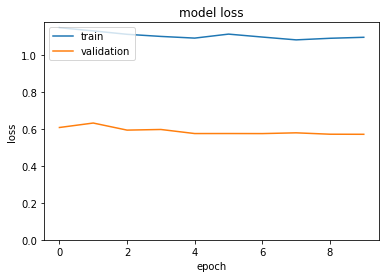

In [164]:
from matplotlib import pyplot as plt
history = NN_transfer.history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(bottom = 0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('best_loss.png')

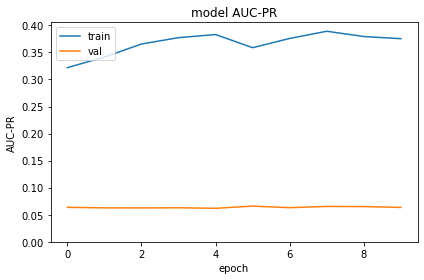

In [175]:
from matplotlib import pyplot as plt
history = NN_transfer.history
plt.plot(history.history['auc_3'])
plt.plot(history.history['val_auc_3'])
plt.ylim(bottom = 0)
plt.title('model AUC-PR')
plt.ylabel('AUC-PR')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.savefig('best_AUC-PR.png')
plt.show()

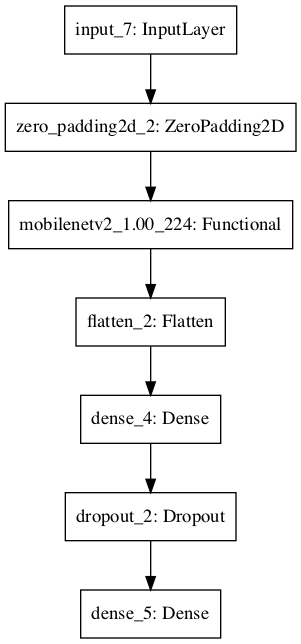

In [23]:
plot_model(
    NN_transfer,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

Now try resnet50 as pre-trained model, ended it because it was slow and not learning

In [133]:
#exclude the final dense layers by setting include_top=False, and add new ones to train from scratch below
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(228,228,3)) 

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    
    
# Establish new fully connected block
NN_transfer1 = Sequential(
                        [InputLayer(input_shape=X_train.shape[1:]),
                         ZeroPadding2D(padding=2),
                         base_model,
                         Flatten(),
                         Dense(32, activation='relu'),
                         Dense(1, activation='sigmoid')]
                       )

NN_transfer1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=metrics_)

In [135]:
NN_transfer1.fit(X_train, y_train_array, epochs=10, verbose=1, batch_size = 100, validation_data = (X_valid, y_valid_array), class_weight=class_weights, callbacks=[tensorboard])

Epoch 1/10
156/156 [==============================] - 1217s 8s/step - loss: 1.3060 - auc_2: 0.5000 - auc_3: 0.0631 - recall_1: 1.0000 - precision_1: 0.0631 - precision_at_recall_1: 0.0631 - true_positives_1: 985.0000 - true_negatives_1: 0.0000e+00 - false_negatives_1: 0.0000e+00 - false_positives_1: 14613.0000 - val_loss: 0.6967 - val_auc_2: 0.5000 - val_auc_3: 0.0631 - val_recall_1: 1.0000 - val_precision_1: 0.0631 - val_precision_at_recall_1: 0.0631 - val_true_positives_1: 328.0000 - val_true_negatives_1: 0.0000e+00 - val_false_negatives_1: 0.0000e+00 - val_false_positives_1: 4872.0000
Epoch 2/10
156/156 [==============================] - 1193s 8s/step - loss: 1.3060 - auc_2: 0.4917 - auc_3: 0.0610 - recall_1: 1.0000 - precision_1: 0.0631 - precision_at_recall_1: 0.0631 - true_positives_1: 985.0000 - true_negatives_1: 0.0000e+00 - false_negatives_1: 0.0000e+00 - false_positives_1: 14613.0000 - val_loss: 0.6965 - val_auc_2: 0.5000 - val_auc_3: 0.0631 - val_recall_1: 1.0000 - val_preci

KeyboardInterrupt: 

In [ ]:
accuracy_score(y_test, np.argmax(NN_transfer1.predict(X_test), axis = -1))

In [ ]:
recall_score(y_test, np.argmax(NN_transfer1.predict(X_test), axis = -1))

In [ ]:
roc_auc_score(y_test, np.argmax(NN_transfer1.predict(X_test), axis = -1))